# Data Assimilation demo in the Lorenz 96 (L96) two time-scale model


# Recap of L96 and notation

[Lorenz (1996)](https://www.ecmwf.int/en/elibrary/10829-predictability-problem-partly-solved) describes a "two time-scale" model in two equations (2 and 3) which are:
\begin{align}
\frac{d}{dt} X_k
&= - X_{k-1} \left( X_{k-2} - X_{k+1} \right) - X_k + F - \left( \frac{hc}{b} \right) \sum_{j=0}^{J-1} Y_{j,k}
\\
\frac{d}{dt} Y_{j,k}
&= - cbY_{j+1,k} \left( Y_{j+2,k} - X_{j-1,k} \right) - c Y_{j,k} + \frac{hc}{b} X_k
\end{align}
(Note that the $F$ term in the top equation is missing in L96 but he provides the parameter and all other authors have it, e.g. [Wilks (2005)](http://rmets.onlinelibrary.wiley.com/doi/abs/10.1256/qj.04.03).)
$X_k$ are the "large scale" with $K$ degrees of freedom ($k=0,1,2,\ldots,K-1$, using python indexing starting at $k=0$). The $k$ index is periodic so that, for example, $k=K$ is referring to $k=0$ and $k=-1$ is referring to $k=K-1$. The $j$ indices represent a sub-division of each $k$-element, so that $J$ Y-values are coupled to a single $X$ value. When $j+1,k$ refers to a values beyond $J$, it is cycled to refer to the first value of with $1,k+1$. The overall structure is illustrated in Fig. 1.


<img src="https://www.researchgate.net/publication/319201436/figure/fig1/AS:869115023589376@1584224577926/Visualisation-of-a-two-scale-Lorenz-96-system-with-J-8-and-K-6-Global-scale-values.png" width=400> *Fig. 1: Visualisation of a two-scale Lorenz '96 system with J = 8 and K = 6. Global-scale values (X k ) are updated based on neighbouring values and a reduction applied to the local-scale values (Y j,k ) associated with that value. Local-scale values are updated based on neighbouring values and the associated global-scale value. The neighbourhood topology of both the local and global-scale values is circular. Image from [Exploiting the chaotic behaviour of atmospheric models with reconfigurable architectures - Scientific Figure on ResearchGate.](https://www.researchgate.net/figure/Visualisation-of-a-two-scale-Lorenz-96-system-with-J-8-and-K-6-Global-scale-values_fig1_319201436)*

# 1. Define variables and functions to use throughout notebook

In [1]:
import inspect
import os
import time

import matplotlib.pyplot as plt
import numpy as np
from L96_model import L96, RK4, L96_2t_xdot_ydot, L96_eq1_xdot, L96s

rng = np.random.default_rng()

config = dict(
    K=40,  # Dimension of L96 "X" variables
    J=10,  # Dimension of L96 "Y" variables
    obs_freq=10,  # observation frequency (number of sampling intervals (si) per observation)
    F_truth=10,  # F for truth signal
    F_fcst=10,  # F for forecast (DA) model
    GCM_param=np.array(
        [0, 0, 0, 0]
    ),  # polynomial coefficicents for GCM parameterization
    ns_da=2000,  # number of time samples for DA
    ns=2000,  # number of time samples for truth signal
    ns_spinup=200,  # number of time samples for spin up
    dt=0.005,  # model timestep
    si=0.005,  # truth sampling interval
    seasonal=False,  # option for adding a seasonal cycle to the forcing in the L96 truth model
    B_loc=5,  # spatial localization radius for DA
    DA="EnKF",  # DA method
    nens=100,  # number of ensemble members for DA
    inflate_opt="relaxation",  # method for DA model covariance inflation
    inflate_factor=0.2,  # inflation factor
    hybrid_factor=0.1,  # inflation factor for hybrid EnKF method
    param_DA=False,  # switch to to parameter estimation with DA
    param_sd=[0.01, 0.02, 0.1, 0.5],  # polynomal parameter standard deviation
    param_inflate="multiplicative",  # method for parameter variance inflation
    param_inf_factor=0.02,  # parameter inflation factor
    obs_density=0.2,  # fraction of spatial gridpoints where observations are collected
    DA_freq=10,  # assimilation frequency (number of sampling intervals (si) per assimilation step)
    obs_sigma=0.5,  # observational error standard deviation
    save_fig=False,  # switch to save figure file
    save_data=False,  #  switch to save
)


def GCM(X0, F, dt, nt, param=[0]):
    """
    2 time-scale model with a parameterised coupling term to represent the interaction
    between the observed coarse scale processes (X) and unobserved fine scale processes (Y).
    Inputs:
        X0: Initial conditions of X (vector of length config['K'])
        F: Forcing (scalar)
        dt: Sampling frequency (timestep) of the model (scalar)
        nt: Number of timesteps for which to run the model (scalar)
        param: Weights to give to the coupling term
    Returns:
        hist: Model output at each timestep (nt + 1 x config['K'])
        time: Corresponding time units for model outputs (nt + 1)
    """
    time, hist, X = (
        dt * np.arange(nt + 1),
        np.zeros((nt + 1, len(X0))) * np.nan,
        X0.copy(),
    )
    hist[0] = X

    for n in range(nt):
        X = X + dt * (L96_eq1_xdot(X, F) - np.polyval(param, X))

        hist[n + 1], time[n + 1] = X, dt * (n + 1)
    return hist, time


def ObsOp(K, l_obs, t_obs, i_t):
    """
    Observation operator to map between model and observation space,
    assuming linearity and model space observations.
    Inputs:
        K: spatial dimension of the model (scalar)
        l_obs: spatial positions of observations on model grid (config['ns_DA']/config['obs_freq'] x config['K']*config['obs_density'])
        t_obs: time positions of observations (config['ns_DA']/config['obs_freq'] x config['K']*config['obs_density'])
        i_t: the timestep of the current DA cycle (scalar)
    Returns:
        H: Operator matrix (config['K']*config['obs_density'] x config['K'])
    """
    n = l_obs.shape[-1]
    H = np.zeros((n, K))
    H[range(n), l_obs[t_obs == i_t]] = 1
    return H


def cov_loc(B, loc=0):
    """
    Localize the model climatology covariance matrix, based on
    the Gaspari-Cohn function
    Inputs:
        B: Covariance matrix over a long model run 'M_truth' (config['K'] x config['K'])
        loc: spatial localization radius for DA (scalar)
    Returns:
        B*W: Covariance matrix scaled to zero outside distance 'loc' from diagonal (config['K'] x config['K'])
        W: Matrix of weights which are used to scale covariance matrix (config['K'] x config['K'])
    """
    M, N = B.shape
    X, Y = np.ix_(np.arange(M), np.arange(N))
    dist = np.vectorize(get_dist)(X, Y, M)
    W = np.vectorize(gaspari_cohn)(dist, loc)
    return B * W, W


def get_dist(i, j, K):
    """
    Compute the absolute distance between two element indices
    within a square matrix of size (K x K)
    Inputs:
        i: the ith row index (scalar)
        j: the jth column index (scalar)
        K: shape of square array (scalar)
    Returns:
        Distance (scalar)
    """
    return abs(i - j) if abs(i - j) <= K / 2 else K - abs(i - j)


def gaspari_cohn(distance, radius):
    """
    Compute the appropriate distance dependent weighting of a
    covariance matrix, after Gaspari & Cohn, 1999 (https://doi.org/10.1002/qj.49712555417)
    Inputs:
        distance: from get_dist(), the distance between array elements (scalar)
        radius: localization radius for DA (scalar)
    Returns:
        weight: distance dependent weight of the ith,jth index of a covariance matrix (scalar)
    """
    if distance == 0:
        weight = 1.0
    else:
        if radius == 0:
            weight = 0.0
        else:
            ratio = distance / radius
            weight = 0.0
            if ratio <= 1:
                weight = (
                    -(ratio**5) / 4
                    + ratio**4 / 2
                    + 5 * ratio**3 / 8
                    - 5 * ratio**2 / 3
                    + 1
                )
            elif ratio <= 2:
                weight = (
                    ratio**5 / 12
                    - ratio**4 / 2
                    + 5 * ratio**3 / 8
                    + 5 * ratio**2 / 3
                    - 5 * ratio
                    + 4
                    - 2 / 3 / ratio
                )
    return weight


def find_obs(loc, obs, t_obs, l_obs, period):
    """
    This function is for plotting purposes only.
    """
    t_period = np.where((t_obs[:, 0] >= period[0]) & (t_obs[:, 0] < period[1]))
    obs_period = np.zeros(t_period[0].shape)
    obs_period[:] = np.nan
    for i in np.arange(len(obs_period)):
        if np.any(l_obs[t_period[0][i]] == loc):
            obs_period[i] = obs[t_period[0][i]][l_obs[t_period[0][i]] == loc]
    return obs_period


def running_ave(X, N):
    """
    Compute running mean over a user-specified window
    Input:
        X: Input vector of arbitrary length 'n'
        N: Size of window over which to compute mean (integer scalar)
    Returns:
        X_sum/N: X averaged over window N
    """
    if N % 2 == 0:
        N1, N2 = -N / 2, N / 2
    else:
        N1, N2 = -(N - 1) / 2, (N + 1) / 2
    X_sum = np.zeros(X.shape)
    for i in np.arange(N1, N2):
        X_sum = X_sum + np.roll(X, int(i), axis=0)
    return X_sum / N

# 2. Generate 'truth' run from two time-scale L96 model

Here we initialise the L96 two time-scale model using a set of random normally distributed values for X, and zeros for Y, and run it forward for a period 'ns_spinup' to allow the model to spinup. Following this, the spunup X and Y components are used as initial conditions for another forward run for a time period 'ns' to represent the unobserved 'truth' field from which our observations will be derived.

Note that in reality we do not observe the fine scale components (the Ys) and so this is what we aim to represent in the parameterisation in the GCM() function

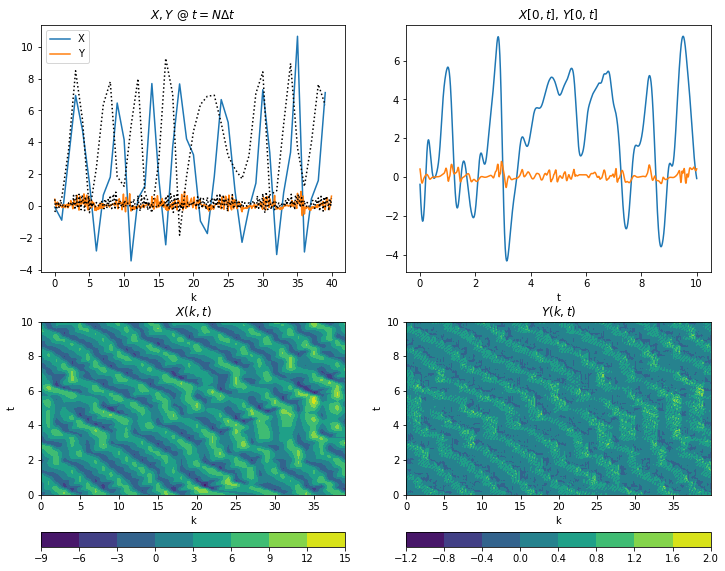

In [2]:
# Set up the "truth" 2-scale L96 model and generate initial conditions from a short spinup
M_truth = L96(
    config["K"], config["J"], F=config["F_truth"], dt=config["dt"]
)  # initialise L96 class
M_truth.set_state(
    rng.standard_normal((config["K"])), 0 * M_truth.j
)  # set initial conditions of X and Y
X_spinup, Y_spinup, t_spinup = M_truth.run(
    config["si"], config["si"] * config["ns_spinup"]
)  # let the model run for 'ns_spinup' number of time steps to spin-up
X_init = X_spinup[
    -1, :
]  # the initial conditions of X for the first forecast (prior to DA) are the last time sample after spinup
Y_init = Y_spinup[-1, :]  # similar for Y

# Run L96 to generate the "truth"
M_truth.set_state(X_init, Y_init)

# # Give F a "seasonal cycle" in the truth model
if config["seasonal"]:
    ann_period = 2000
    mon_period = 100
    mon_per_ann = ann_period / mon_period
    X_truth, Y_truth, t_truth = M_truth.run(config["si"], config["si"] * mon_period)
    for i in range(1, int(config["ns"] / mon_period)):
        M_truth.set_state(X_truth[-1, ...], Y_truth[-1, ...])
        M_truth.set_param(F=config["F_truth"] + 2 * np.sin(2 * np.pi * i / mon_per_ann))
        X_step, Y_step, t_step = M_truth.run(config["si"], config["si"] * mon_period)
        X_truth = np.concatenate((X_truth, X_step[1:None, ...]))
        Y_truth = np.concatenate((Y_truth, Y_step[1:None, ...]))
        t_truth = np.concatenate((t_truth, t_truth[-1] + t_step[1:None]))
else:
    X_truth, Y_truth, t_truth = M_truth.run(config["si"], config["si"] * config["ns"])

# generate climatological background (temporal) covariance for 2-scale L96 model
B_clim = np.cov(X_truth.T)
np.save("B_clim_L96.npy", B_clim)

plt.figure(figsize=(12, 10))
plt.subplot(221)
# Snapshot of X[k]
plt.plot(M_truth.k, X_truth[-1, :], label="X")
plt.plot(M_truth.j / M_truth.J, Y_truth[-1, :], label="Y")
plt.legend()
plt.xlabel("k")
plt.title("$X,Y$ @ $t=N\Delta t$")
plt.plot(M_truth.k, X_truth[0, :], "k:")
plt.plot(M_truth.j / M_truth.J, Y_truth[0, :], "k:")
plt.subplot(222)
# Sample time-series X[0](t), Y[0](t)
plt.plot(t_truth, X_truth[:, 0], label="X")
plt.plot(t_truth, Y_truth[:, 0], label="Y")
plt.xlabel("t")
plt.title("$X[0,t]$, $Y[0,t]$")
plt.subplot(223)
# Full model history of X
plt.contourf(M_truth.k, t_truth, X_truth)
plt.colorbar(orientation="horizontal")
plt.xlabel("k")
plt.ylabel("t")
plt.title("$X(k,t)$")
plt.subplot(224)
# Full model history of Y
plt.contourf(M_truth.j / M_truth.J, t_truth, Y_truth)
plt.colorbar(orientation="horizontal")
plt.xlabel("k")
plt.ylabel("t")
plt.title("$Y(k,t)$");

# # generate climatological background covariance for 1-scale L96 model
# M_1s = L96s(config['K'], F=config['F_truth'], dt=config['dt'], method=RK4)
# M_1s.set_state(X_init)
# X1_truth,t1_truth = M_1s.run(config['si']*config['ns'])
# B_clim_1s = np.cov(X1_truth.T)
# np.save('B_clim_1s.npy', B_clim_1s)

# 3. Generate synthetic observations

Here we generate a set of sparse observations by sampling from the X_truth run, and adding random Gaussian noise. 

The covariance matrix over the observations 'R' (used to express the uncertainty in the observations during DA) is given as a diagonal matrix with entries defined by config['obs_sigma']**2

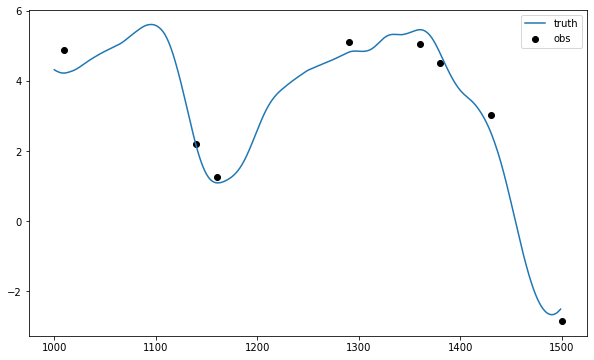

In [3]:
# Sample the "truth" to generate observations at certain times (t_obs) and locations (l_obs)
t_obs = np.tile(
    np.arange(
        config["obs_freq"], config["ns_da"] + config["obs_freq"], config["obs_freq"]
    ),
    [int(config["K"] * config["obs_density"]), 1],
).T
l_obs = np.zeros(t_obs.shape, dtype="int")
for i in range(l_obs.shape[0]):
    l_obs[i, :] = rng.choice(
        config["K"], int(config["K"] * config["obs_density"]), replace=False
    )
X_obs = X_truth[t_obs, l_obs] + config["obs_sigma"] * rng.standard_normal(l_obs.shape)

# Calculated observation covariance matrix, assuming independent observations
R = config["obs_sigma"] ** 2 * np.eye(int(config["K"] * config["obs_density"]))

plt.figure(figsize=[10, 6])
plt.plot(range(1000, 1500), X_truth[1000:1500, 0], label="truth")
plt.scatter(
    t_obs[100:150, 0],
    find_obs(0, X_obs, t_obs, l_obs, [t_obs[100, 0], t_obs[150, 0]]),
    color="k",
    label="obs",
)
plt.legend()

# 4. Apply localization to the background model covariance

The covariance of the model climatology was computed a-priori form a long run. In this step we apply the localized weighting to the covariance matrix 

Text(0.5, 1.0, 'Background correlation matrix 2-scale L96')

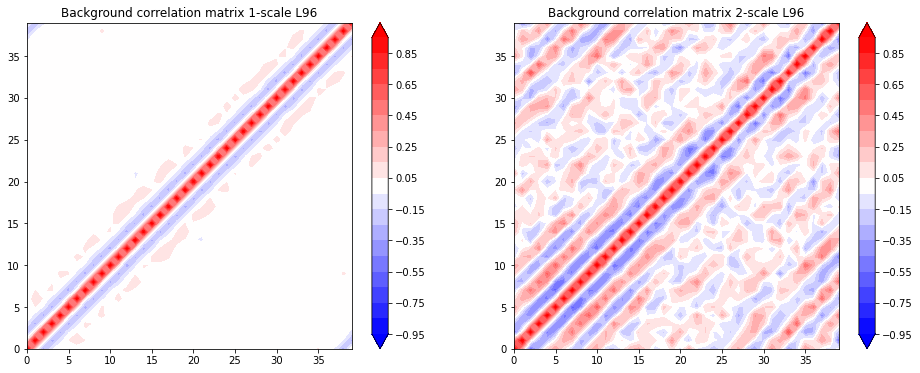

In [4]:
import importlib

import DA_methods

importlib.reload(DA_methods)

# load pre-calculated climatological background covariance matrix from a long simulation
B_clim1 = np.load("B_clim_L96s.npy")
B_loc, W_clim = cov_loc(B_clim1, loc=config["B_loc"])

B_clim2 = np.load("B_clim_L96.npy")
B_corr1 = np.zeros(B_clim1.shape)
B_corr2 = np.zeros(B_clim2.shape)
for i in range(B_clim1.shape[0]):
    for j in range(B_clim1.shape[1]):
        B_corr1[i, j] = B_clim1[i, j] / np.sqrt(B_clim1[i, i] * B_clim1[j, j])
        B_corr2[i, j] = B_clim2[i, j] / np.sqrt(B_clim2[i, i] * B_clim2[j, j])

plt.figure(figsize=(16, 6))
plt.subplot(121)
plt.contourf(B_corr1, cmap="bwr", extend="both", levels=np.linspace(-0.95, 0.95, 20))
plt.colorbar()
plt.title("Background correlation matrix 1-scale L96")
plt.subplot(122)
plt.contourf(B_corr2, cmap="bwr", extend="both", levels=np.linspace(-0.95, 0.95, 20))
plt.colorbar()
plt.title("Background correlation matrix 2-scale L96")

# 4. Run Data Assimilation

During each DA cycle produce an updated state estimate for all K grid points, and all n number of ensemble members

Inputs: prior estimate (the forecast at time t for all K grid points, and all n number of ensemble members)
        observations (N observations)
        operator matrix (N x K)
        covariance over obs (N x N)
        covariance over model (K x K)

In [5]:
t0 = time.time()
# set up array to store DA increments
X_inc = np.zeros(
    (int(config["ns_da"] / config["DA_freq"]), config["K"], config["nens"])
)
if config["DA"] == "3DVar":
    X_inc = np.squeeze(X_inc)
t_DA = np.zeros(int(config["ns_da"] / config["DA_freq"]))

# initialize ensemble with perturbations
i_t = 0
ensX = X_init[None, :, None] + rng.standard_normal((1, config["K"], config["nens"]))
X_post = ensX[0, ...]


if config["param_DA"]:
    mean_param = np.zeros(
        (int(config["ns_da"] / config["DA_freq"]), len(config["GCM_param"]))
    )
    spread_param = np.zeros(
        (int(config["ns_da"] / config["DA_freq"]), len(config["GCM_param"]))
    )
    param_scale = config["param_sd"]
    W = np.ones(
        (config["K"] + len(config["GCM_param"]), config["K"] + len(config["GCM_param"]))
    )
    W[0 : config["K"], 0 : config["K"]] = W_clim
else:
    W = W_clim
    param_scale = np.zeros(config["GCM_param"].shape)

ens_param = np.zeros((len(config["GCM_param"]), config["nens"]))
for i in range(len(config["GCM_param"])):
    ens_param[i, :] = config["GCM_param"][i] + rng.normal(
        scale=param_scale[i], size=config["nens"]
    )

# DA cycles
for cycle in np.arange(0, config["ns_da"] / config["DA_freq"], dtype="int"):
    # for cycle in np.arange(0,1,dtype='int'):

    # set up array to store model forecast for each DA cycle
    ensX_fcst = np.zeros((config["DA_freq"] + 1, config["K"], config["nens"]))
    # model forecast for next DA cycle
    for n in range(config["nens"]):
        ensX_fcst[..., n] = GCM(
            X_post[0 : config["K"], n],
            config["F_fcst"],
            config["dt"],
            config["DA_freq"],
            ens_param[:, n],
        )[0]
    i_t = i_t + config["DA_freq"]

    # get prior/background from the forecast
    X_prior = ensX_fcst[-1, ...]  # get prior from model integration

    # call DA
    t_DA[cycle] = t_truth[i_t]
    if config["DA"] == "EnKF":
        H = ObsOp(config["K"], l_obs, t_obs, i_t)
        # augment state vector with parameters when doing parameter estimation
        if config["param_DA"]:
            H = np.concatenate(
                (H, np.zeros((H.shape[0], len(config["GCM_param"])))), axis=-1
            )
            X_prior = np.concatenate((X_prior, ens_param))
        B_ens = np.cov(X_prior)
        B_ens_loc = B_ens * W
        X_post = DA_methods.EnKF(X_prior, X_obs[t_obs == i_t], H, R, B_ens_loc)

        X_post[0 : config["K"], :] = DA_methods.ens_inflate(
            X_post[0 : config["K"], :],
            X_prior[0 : config["K"], :],
            config["inflate_opt"],
            config["inflate_factor"],
        )
        if config["param_DA"]:
            X_post[-len(config["GCM_param"]) : None, :] = DA_methods.ens_inflate(
                X_post[-len(config["GCM_param"]) : None, :],
                X_prior[-len(config["GCM_param"]) : None, :],
                config["param_inflate"],
                config["param_inf_factor"],
            )
            ens_param = X_post[-len(config["GCM_param"]) : None, :]
    elif config["DA"] == "HyEnKF":
        H = ObsOp(config["K"], l_obs, t_obs, i_t)
        B_ens = (
            np.cov(X_prior) * (1 - config["hybrid_factor"])
            + B_clim1 * config["hybrid_factor"]
        )
        B_ens_loc = B_ens * W
        X_post = DA_methods.EnKF(X_prior, X_obs[t_obs == i_t], H, R, B_ens_loc)
        X_post = DA_methods.ens_inflate(
            X_post, X_prior, config["inflate_opt"], config["inflate_factor"]
        )
    elif config["DA"] == "3DVar":
        X_prior = np.squeeze(X_prior)
        H = ObsOp(config["K"], l_obs, t_obs, i_t)
        X_post = DA_methods.Lin3dvar(X_prior, X_obs[t_obs == i_t], H, R, B_loc, 3)
    elif config["DA"] == "Replace":
        X_post = X_prior
        X_post[l_obs[t_obs == i_t]] = X_obs[t_obs == i_t]
    elif config["DA"] == "None":
        X_post = X_prior

    if not config["DA"] == "None":
        X_inc[cycle, ...] = (
            np.squeeze(X_post[0 : config["K"], ...]) - X_prior[0 : config["K"], ...]
        )  # get current increments
        # get posterior info about the estimated parameters
        if config["param_DA"]:
            mean_param[cycle, :] = ens_param.mean(axis=-1)
            spread_param[cycle, :] = ens_param.std(axis=-1)

    # reset initial conditions for next DA cycle
    ensX_fcst[-1, :, :] = X_post[0 : config["K"], :]
    ensX = np.concatenate((ensX, ensX_fcst[1:None, ...]))

print("time to complete DA: ", round(time.time() - t0, 2), " (s)")

time to complete DA:  8.55  (s)


# 5. Post processing and visualization

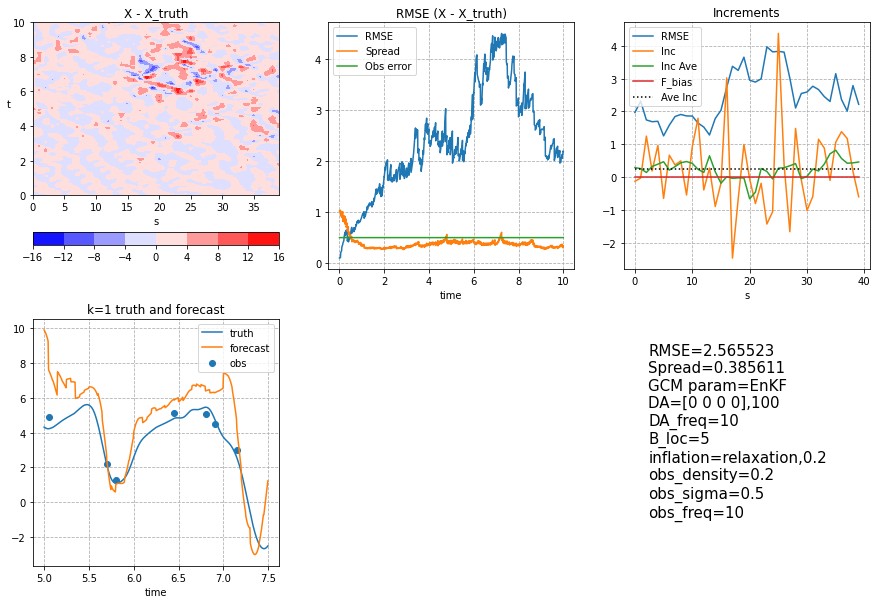

In [6]:
meanX = np.mean(ensX, axis=-1)
clim = np.max(np.abs(meanX - X_truth[0 : (config["ns_da"] + 1), :]))

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
ch = axes[0, 0].contourf(
    M_truth.k,
    t_truth[0 : (config["ns_da"] + 1)],
    meanX - X_truth[0 : (config["ns_da"] + 1), :],
    cmap="bwr",
    vmin=-clim,
    vmax=clim,
    extend="neither",
)
plt.colorbar(ch, ax=axes[0, 0], orientation="horizontal")
axes[0, 0].set_xlabel("s")
axes[0, 0].set_ylabel("t", rotation=0)
axes[0, 0].set_title("X - X_truth")
axes[0, 1].plot(
    t_truth[0 : (config["ns_da"] + 1)],
    np.sqrt(((meanX - X_truth[0 : (config["ns_da"] + 1), :]) ** 2).mean(axis=-1)),
    label="RMSE",
)
axes[0, 1].plot(
    t_truth[0 : (config["ns_da"] + 1)],
    np.mean(np.std(ensX, axis=-1), axis=-1),
    label="Spread",
)
axes[0, 1].plot(
    t_truth[0 : (config["ns_da"] + 1)],
    config["obs_sigma"] * np.ones((config["ns_da"] + 1)),
    label="Obs error",
)
axes[0, 1].legend()
axes[0, 1].set_xlabel("time")
axes[0, 1].set_title("RMSE (X - X_truth)")
axes[0, 1].grid(which="both", linestyle="--")

axes[0, 2].plot(
    M_truth.k,
    np.sqrt(((meanX - X_truth[0 : (config["ns_da"] + 1), :]) ** 2).mean(axis=0)),
    label="RMSE",
)
X_inc_ave = X_inc / config["DA_freq"] / config["si"]
axes[0, 2].plot(M_truth.k, X_inc_ave.mean(axis=(0, -1)), label="Inc")
axes[0, 2].plot(
    M_truth.k, running_ave(X_inc_ave.mean(axis=(0, -1)), 7), label="Inc Ave"
)
axes[0, 2].plot(
    M_truth.k,
    np.ones(M_truth.k.shape) * (config["F_fcst"] - config["F_truth"]),
    label="F_bias",
)
axes[0, 2].plot(
    M_truth.k,
    np.ones(M_truth.k.shape) * (X_inc / config["DA_freq"] / config["si"]).mean(),
    "k:",
    label="Ave Inc",
)
axes[0, 2].legend()
axes[0, 2].set_xlabel("s")
axes[0, 2].set_title("Increments")
axes[0, 2].grid(which="both", linestyle="--")

# X_inc_ave=(X_inc/config['DA_freq']/config['si']).mean(axis=(1,2)).\
#         reshape(int(config['ns_da']/ann_period),int(ann_period/config['DA_freq'])).mean(axis=0)
# axes[0,2].plot(np.arange(ann_period/config['DA_freq']),X_inc_ave,label='Inc')
# axes[0,2].plot(np.arange(ann_period/config['DA_freq']),running_ave(X_inc_ave,10),label='Inc Ave');
# axes[0,2].plot(np.arange(0,ann_period/config['DA_freq'],mon_period/config['DA_freq']),
#                -2*np.sin(2*np.pi*np.arange(mon_per_ann)/mon_per_ann),label='F_bias')
# axes[0,2].legend()
# axes[0,2].set_xlabel('"annual cycle"'); axes[0,2].set_title('Increments');
# axes[0,2].grid(which='both',linestyle='--')

plot_start, plot_end = 1000, 1500
plot_start_DA, plot_end_DA = int(plot_start / config["DA_freq"]), int(
    plot_end / config["DA_freq"]
)
plot_x = 0
axes[1, 0].plot(
    t_truth[plot_start:plot_end], X_truth[plot_start:plot_end, plot_x], label="truth"
)
axes[1, 0].plot(
    t_truth[plot_start:plot_end], meanX[plot_start:plot_end, plot_x], label="forecast"
)
axes[1, 0].scatter(
    t_DA[plot_start_DA - 1 : plot_end_DA - 1],
    find_obs(plot_x, X_obs, t_obs, l_obs, [plot_start, plot_end]),
    label="obs",
)
axes[1, 0].grid(which="both", linestyle="--")
axes[1, 0].set_xlabel("time")
axes[1, 0].set_title("k=" + str(plot_x + 1) + " truth and forecast")
axes[1, 0].legend()

if config["param_DA"]:
    for i, c in zip(np.arange(len(config["GCM_param"]), 0, -1), ["r", "b", "g", "k"]):
        axes[1, 1].plot(
            t_DA,
            running_ave(mean_param[:, i - 1], 100),
            c + "-",
            label="C{} {:3f}".format(
                i - 1, mean_param[int(len(t_DA) / 2) : None, i - 1].mean()
            ),
        )
        axes[1, 1].plot(
            t_DA,
            running_ave(mean_param[:, i - 1] + spread_param[:, i - 1], 100),
            c + ":",
            label="SD {:3f}".format(
                spread_param[int(len(t_DA) / 2) : None, i - 1].mean()
            ),
        )
        axes[1, 1].plot(
            t_DA,
            running_ave(mean_param[:, i - 1] - spread_param[:, i - 1], 100),
            c + ":",
        )
    axes[1, 1].legend()
    axes[1, 1].grid(which="both", linestyle="--")

else:
    axes[1, 1].axis("off")

axes[1, 2].text(
    0.1,
    0.2,
    "RMSE={:3f}\nSpread={:3f}\nGCM param={}\nDA={},{}\nDA_freq={}\nB_loc={}\ninflation={},{}\nobs_density={}\nobs_sigma={}\nobs_freq={}".format(
        np.sqrt(((meanX - X_truth[0 : (config["ns_da"] + 1), :]) ** 2).mean()),
        np.mean(np.std(ensX, axis=-1)),
        config["DA"],
        config["GCM_param"],
        config["nens"],
        config["DA_freq"],
        config["B_loc"],
        config["inflate_opt"],
        config["inflate_factor"],
        config["obs_density"],
        config["obs_sigma"],
        config["obs_freq"],
    ),
    fontsize=15,
)
axes[1, 2].axis("off")

if config["save_fig"]:
    data_path = "./DA_data/"
    if not os.path.isdir(data_path):
        os.mkdir(data_path)
    exp_number = np.random.randint(1, 10000)
    f = open(data_path + "config_{0}.txt".format(exp_number), "w")
    f.write(data_path + str(config))
    f.close()
    plt.savefig(data_path + "fig_{0}.png".format(exp_number))

In [7]:
# save DA output for further analysis
if config["save_data"]:
    config_str = (
        "K_"
        + str(config["K"])
        + "_J_"
        + str(config["J"])
        + "_obs_freq_"
        + str(config["obs_freq"])
        + "_F_truth_"
        + str(config["F_truth"])
        + "_F_fcst_"
        + str(config["F_fcst"])
        + "_ns_da_"
        + str(config["ns_da"])
        + "_ns_"
        + str(config["ns"])
        + "_ns_spinup_"
        + str(config["ns_spinup"])
        + "_dt_"
        + str(config["dt"])
        + "_si_"
        + str(config["si"])
        + "_B_loc_"
        + str(config["B_loc"])
        + "_DA_"
        + str(config["DA"])
        + "_nens_"
        + str(config["nens"])
        + "_inflate_opt_"
        + str(config["inflate_opt"])
        + "_inflate_factor_"
        + str(config["inflate_factor"])
        + "_hybrid_factor_"
        + str(config["hybrid_factor"])
        + "_obs_density_"
        + str(config["obs_density"])
        + "_DA_freq_"
        + str(config["DA_freq"])
        + "_obs_sigma_"
        + str(config["obs_sigma"])
        + ".npz"
    )

    data_path = "./DA_data/"
    if not os.path.isdir(data_path):
        os.mkdir(data_path)

    # np.savez(data_path+config_str,meanX=meanX,ensX=ensX,X_truth=X_truth,X_inc=X_inc,X_inc_ave=X_inc_ave)
    np.savez(data_path + config_str, meanX=meanX, X_truth=X_truth, X_inc_ave=X_inc_ave)